# samv2

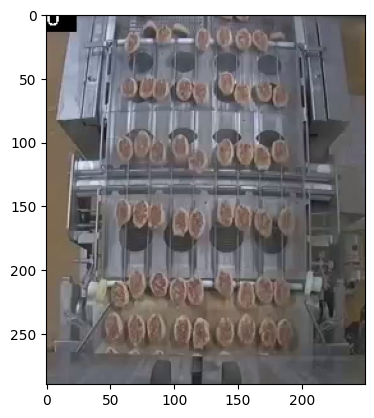

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

img_path = "../../data/processed/meatballs/images/train/frame_000000.PNG"

img = Image.open(img_path)
img = np.array(img.convert("RGB"))

img = img[10:300, 200:450]

plt.imshow(img)

In [89]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2
from sam2.utils.misc import variant_to_config_mapping
from sam2.utils.visualization import show_masks

model = build_sam2(
    variant_to_config_mapping["base_plus"],
    "../models/sam2_hiera_base_plus.pt",
)

mask_generator = SAM2AutomaticMaskGenerator(model)



In [90]:
masks = mask_generator.generate(img)

In [91]:
print(masks[0]['segmentation'].shape)
print(img.shape)


(290, 250)
(290, 250, 3)


In [92]:
from typing import Optional, Union, List, Dict

import numpy as np
from PIL import Image


def show_masks_fixed(
    image: np.ndarray,
    masks: Union[np.ndarray, List[Dict]],
    scores: Optional[np.ndarray] = None,
    alpha: Optional[float] = 0.5,
    display_image: Optional[bool] = True,  # Changed default to True
    only_best: Optional[bool] = True,
    autogenerated_mask: Optional[bool] = False,
) -> Image.Image:
    """
    Display segmentation masks on an image.
    
    Parameters:
        image (np.ndarray): Input image as a numpy array.
        masks (np.ndarray or List[Dict]): Either a numpy array of masks or a list of dictionaries
                                         with "segmentation" and "area" keys.
        scores (np.ndarray, optional): Confidence scores for masks.
        alpha (float, optional): Transparency of masks. Default is 0.5.
        display_image (bool, optional): Whether to display masks on the input image. Default is False.
        only_best (bool, optional): Whether to only display the mask with highest score. Default is True.
        autogenerated_mask (bool, optional): Whether masks are in autogenerated format. Default is False.
        
    Returns:
        PIL.Image.Image: Image with overlaid masks
    """
    # Handle sorting by scores if provided
    if scores is not None and not autogenerated_mask:
        # Sort masks by their scores
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]

    # Get dimensions from the input
    if display_image:
        # Use the input image dimensions
        if image.ndim == 3:  # Color image
            h, w = image.shape[:2]
        else:  # Grayscale image
            h, w = image.shape
    elif autogenerated_mask:
        # For autogenerated masks, get dimensions from the first mask
        if isinstance(masks, list) and masks and 'segmentation' in masks[0]:
            h, w = masks[0]['segmentation'].shape
        else:
            raise ValueError("Autogenerated masks should be a list of dictionaries with 'segmentation' key")
    else:
        # For regular masks, get dimensions from the mask array
        if masks.ndim == 3:  # Multiple masks
            h, w = masks.shape[1:]
        else:  # Single mask
            h, w = masks.shape

    # Prepare the output image
    if display_image:
        # Convert input image to PIL and ensure RGBA mode
        if image.dtype == np.uint8:
            output_image = Image.fromarray(image)
        else:
            output_image = Image.fromarray((image * 255).astype(np.uint8))
            
        if output_image.mode != 'RGBA':
            output_image = output_image.convert('RGBA')
    else:
        # Create a new blank image
        output_image = Image.new(mode="RGBA", size=(w, h), color=(0, 0, 0, 0))  # Fully transparent
        
        # If we have the original image, blend it in even when display_image is False
        # This ensures masks are displayed on top of the original image
        if image is not None:
            img_pil = Image.fromarray(image if image.dtype == np.uint8 else (image * 255).astype(np.uint8))
            if img_pil.mode != 'RGBA':
                img_pil = img_pil.convert('RGBA')
            # Resize if needed
            if img_pil.size != output_image.size:
                img_pil = img_pil.resize((w, h))
            output_image = img_pil.copy()

    # Process each mask
    if autogenerated_mask:
        # Sort by area if autogenerated
        if isinstance(masks, list) and masks and 'area' in masks[0]:
            masks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    
    # Iterate through masks
    mask_count = len(masks) if isinstance(masks, list) else masks.shape[0]
    for i in range(mask_count):
        if autogenerated_mask:
            if isinstance(masks, list) and 'segmentation' in masks[i]:
                mask = masks[i]["segmentation"]
            else:
                raise ValueError("Expected masks to be a list of dicts with 'segmentation' key when autogenerated_mask=True")
        else:
            if masks.ndim > 2:
                mask = masks[i]
                if mask.ndim > 2:  # Handle extra dimensions
                    mask = mask.squeeze()
            else:
                mask = masks  # Single mask case

        # Generate a random color with specified alpha value
        color = np.concatenate(
            (np.random.randint(0, 256, size=3), [int(alpha * 255)]), axis=0
        )

        # Create an RGBA image for the mask
        # Ensure mask has values 0-1 for binary mask
        if mask.dtype != np.bool_:
            if np.max(mask) > 1.0:
                mask = (mask > 0).astype(np.uint8)
            else:
                mask = (mask > 0.5).astype(np.uint8)
        
        # Print debug info (uncomment if needed)
        # print(f"Mask shape: {mask.shape}, Output image size: {output_image.size}")
        
        # Ensure mask dimensions match output_image dimensions (width×height in PIL)
        expected_h, expected_w = output_image.size[1], output_image.size[0]
        if mask.shape[0] != expected_h or mask.shape[1] != expected_w:
            # Resize mask to match output_image dimensions
            # Note: NumPy and PIL have different dimension ordering
            mask_resized = np.zeros((expected_h, expected_w), dtype=mask.dtype)
            # Copy values where possible
            min_h = min(mask.shape[0], expected_h)
            min_w = min(mask.shape[1], expected_w)
            mask_resized[:min_h, :min_w] = mask[:min_h, :min_w]
            mask = mask_resized
                
        mask_image = Image.fromarray((mask * 255).astype(np.uint8)).convert("L")
        mask_colored = Image.new("RGBA", mask_image.size, tuple(color))
        mask_overlay = Image.new("RGBA", mask_image.size, (0, 0, 0, 0))
        mask_image = Image.composite(mask_colored, mask_overlay, mask_image)

        # Overlay mask on the output image
        output_image = Image.alpha_composite(output_image, mask_image)

        # Exit if specified to only display the best mask
        if only_best:
            break

    return output_image

In [93]:
output_mask = show_masks_fixed(image = img, masks = masks, scores=None, only_best=False, autogenerated_mask=True)

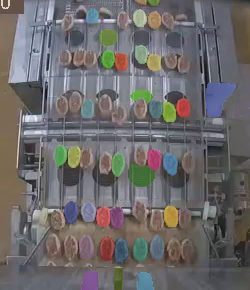

In [94]:
output_mask

# Sparse models

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import cv2
from PIL import Image
import os
import json
import glob
import shutil
from pathlib import Path

class SegmentationKNN:
    def __init__(self, n_neighbors=5):
        """
        Initialize the SegmentationKNN model with a ResNet18 feature extractor
        
        Args:
            n_neighbors: Number of neighbors for KNN algorithm
        """
        # Initialize ResNet18 as feature extractor
        self.feature_extractor = models.resnet18(pretrained=True)
        # Remove the final fully connected layer
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1])
        self.feature_extractor.eval()  # Set to evaluation mode
        
        # Initialize KNN classifier
        self.knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        
        # Define image transformation pipeline
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # For storing features and labels during training
        self.features = []
        self.labels = []
    
    def extract_features(self, image, mask):
        """
        Extract features from an image region defined by a mask using ResNet18
        
        Args:
            image: PIL Image or numpy array
            mask: Binary mask indicating the region of interest
        
        Returns:
            feature_vector: Extracted feature vector for the masked region
        """
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        # Apply mask to the image
        if isinstance(mask, np.ndarray):
            masked_image = np.copy(image)
            if len(mask.shape) == 2:  # Binary mask
                if len(np.array(image).shape) == 3:  # RGB image
                    for c in range(3):  # Apply mask to each channel
                        masked_image[:, :, c] = masked_image[:, :, c] * mask
                else:  # Grayscale image
                    masked_image = masked_image * mask
            masked_image = Image.fromarray(masked_image.astype(np.uint8))
        else:
            raise ValueError("Mask must be a numpy array")
        
        # Transform the masked image for ResNet
        input_tensor = self.transform(masked_image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
        
        # Extract features
        with torch.no_grad():
            features = self.feature_extractor(input_batch)
        
        # Flatten the features
        feature_vector = features.squeeze().flatten().numpy()
        
        return feature_vector
    
    def fit(self, images, masks, labels):
        """
        Train the KNN classifier with features extracted from masked regions
        
        Args:
            images: List of images
            masks: List of binary masks corresponding to images
            labels: List of labels for each mask
        """
        self.features = []
        self.labels = []
        
        for i in range(len(images)):
            feature = self.extract_features(images[i], masks[i])
            self.features.append(feature)
            self.labels.append(labels[i])
        
        # Train KNN with extracted features
        self.knn.fit(self.features, self.labels)
    
    def predict(self, image, candidate_masks, target_class=None):
        """
        Predict labels for candidate masks and filter out those that don't fit
        Keep only masks that match the target class
        
        Args:
            image: Input image
            candidate_masks: List of candidate segmentation masks
            target_class: The specific class to keep (if None, use distance-based filtering)
        
        Returns:
            filtered_masks: List of masks that fit according to KNN
            predicted_labels: Corresponding predicted labels
        """
        if not candidate_masks or len(candidate_masks) == 0:
            return [], []
            
        features = []
        for mask in candidate_masks:
            feature = self.extract_features(image, mask)
            features.append(feature)
        
        # Predict labels and get distances
        predicted_labels = self.knn.predict(features)
        distances, indices = self.knn.kneighbors(features)
        
        if target_class is not None:
            # Keep only the masks that match the target class
            filtered_indices = [i for i, label in enumerate(predicted_labels) if label == target_class]
        else:
            # Default behavior: filter based on distance threshold
            max_distance = np.mean(distances) + np.std(distances)
            filtered_indices = [i for i, d in enumerate(distances) if np.mean(d) <= max_distance]
        
        filtered_masks = [candidate_masks[i] for i in filtered_indices]
        filtered_labels = [predicted_labels[i] for i in filtered_indices]
        
        return filtered_masks, filtered_labels


# Usage example with YOLO format data
def main():
    """
    Example usage of the YOLO segmentation KNN pipeline
    """
    # Set up parameters
    data_dir = "path/to/training/data"  # Directory with images/ and labels/ subdirectories
    target_class = "desired_class"  # Replace with your target class name
    output_dir = "path/to/output"
    
    # Train KNN model from YOLO format data
    # Only using masks from the target class for training
    knn_model = train_knn_from_yolo(data_dir, target_class=target_class, n_neighbors=5)
    
    # Run inference on test data
    test_data_dir = "path/to/test/data"
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all test images and their label files
    test_img_files = sorted(glob.glob(str(Path(test_data_dir) / "images" / "*.jpg")) + 
                           glob.glob(str(Path(test_data_dir) / "images" / "*.jpeg")) + 
                           glob.glob(str(Path(test_data_dir) / "images" / "*.png")))
    
    for img_path in test_img_files:
        img_path = Path(img_path)
        label_path = Path(test_data_dir) / "labels" / f"{img_path.stem}.txt"
        
        if not label_path.exists():
            continue
        
        # Load image and masks
        image, candidate_masks = convert_yolo_masks_to_binary(img_path, label_path)
        
        # Apply KNN to filter masks
        filtered_masks, _ = knn_model.predict(image, candidate_masks, target_class=target_class)
        
        if filtered_masks:
            # Save results
            output_label_path = Path(output_dir) / "labels" / f"{img_path.stem}.txt"
            os.makedirs(output_label_path.parent, exist_ok=True)
            
            # Get original image dimensions for YOLO normalization
            orig_img = cv2.imread(str(img_path))
            orig_h, orig_w = orig_img.shape[:2]
            
            # Save filtered masks back to YOLO format
            save_filtered_masks_as_yolo(filtered_masks, output_label_path, orig_w, orig_h)
            
            # Copy the original image to output directory
            output_img_path = Path(output_dir) / "images" / img_path.name
            os.makedirs(output_img_path.parent, exist_ok=True)
            shutil.copy(img_path, output_img_path)
            
            # Create visualization
            vis_img_path = Path(output_dir) / "visualizations" / f"{img_path.stem}_filtered.jpg"
            os.makedirs(vis_img_path.parent, exist_ok=True)
            
            # Visualize with fake labels (since we only care about the masks)
            vis_labels = [target_class] * len(filtered_masks)
            vis_image = visualize_results(image, filtered_masks, vis_labels)
            cv2.imwrite(str(vis_img_path), cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR))
    
    print(f"Processing complete. Results saved to {output_dir}")


if __name__ == "__main__":
    main()


class YOLOSegmentationDataset(Dataset):
    """
    Dataset class for loading YOLO format segmentation masks and images
    """
    def __init__(self, data_dir, img_size=(640, 640), transform=None, class_mapping=None):
        """
        Initialize YOLO segmentation dataset
        
        Args:
            data_dir: Directory containing images and labels in YOLO format
            img_size: Size to resize images to
            transform: Optional transforms to apply to images
            class_mapping: Dictionary mapping class IDs to class names
        """
        self.data_dir = Path(data_dir)
        self.img_size = img_size
        self.transform = transform
        
        # Find all image files
        self.img_files = sorted(glob.glob(str(self.data_dir / "images" / "*.jpg")) + 
                               glob.glob(str(self.data_dir / "images" / "*.jpeg")) + 
                               glob.glob(str(self.data_dir / "images" / "*.png")))
        
        # Get corresponding label files
        self.label_files = []
        for img_file in self.img_files:
            img_path = Path(img_file)
            label_file = self.data_dir / "labels" / f"{img_path.stem}.txt"
            if label_file.exists():
                self.label_files.append(str(label_file))
            else:
                # If no label file, remove the image file from the list
                self.img_files.remove(img_file)
        
        # Set up class mapping
        self.class_mapping = class_mapping
        if self.class_mapping is None:
            # Try to load from data.yaml if exists
            yaml_file = self.data_dir / "data.yaml"
            if yaml_file.exists():
                try:
                    import yaml
                    with open(yaml_file, 'r') as f:
                        data = yaml.safe_load(f)
                    if 'names' in data and isinstance(data['names'], dict):
                        self.class_mapping = data['names']
                    elif 'names' in data and isinstance(data['names'], list):
                        self.class_mapping = {i: name for i, name in enumerate(data['names'])}
                except:
                    # Default to class IDs if YAML file can't be loaded
                    self.class_mapping = {}
            else:
                self.class_mapping = {}
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        """
        Get image, all masks, and labels for an index
        """
        # Load image
        img_path = self.img_files[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        
        # Resize image
        image = cv2.resize(image, self.img_size)
        h, w = self.img_size
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
        
        # Load labels
        label_path = self.label_files[idx]
        masks = []
        class_ids = []
        
        with open(label_path, 'r') as f:
            for line in f.readlines():
                data = line.strip().split()
                if len(data) < 5:  # Not a valid segmentation line
                    continue
                
                class_id = int(data[0])
                class_ids.append(class_id)
                
                # Get label name if available
                if class_id in self.class_mapping:
                    label = self.class_mapping[class_id]
                else:
                    label = f"class_{class_id}"
                
                # Extract polygon points (YOLO format is normalized)
                polygon = []
                for i in range(1, len(data), 2):
                    if i+1 < len(data):
                        # Convert normalized coordinates to pixel coordinates
                        x = float(data[i]) * w
                        y = float(data[i+1]) * h
                        polygon.append((int(x), int(y)))
                
                # Create binary mask from polygon
                if len(polygon) >= 3:  # Need at least 3 points to create a polygon
                    mask = np.zeros((h, w), dtype=np.uint8)
                    cv2.fillPoly(mask, [np.array(polygon)], 1)
                    masks.append(mask)
                else:
                    # If not enough points, add a dummy mask and continue
                    masks.append(np.zeros((h, w), dtype=np.uint8))
                    continue
        
        # Convert class IDs to labels
        labels = [self.class_mapping.get(cid, f"class_{cid}") for cid in class_ids]
        
        return {
            'image': image,
            'masks': masks,
            'labels': labels,
            'image_path': img_path
        }
    
    def get_image_masks(self, idx):
        """
        Get all masks for a single image (for use with KNN)
        """
        item = self.__getitem__(idx)
        return item['image'], item['masks'], item['labels']
    
    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function to handle variable number of masks per image
        """
        images = [item['image'] for item in batch]
        all_masks = [item['masks'] for item in batch]
        all_labels = [item['labels'] for item in batch]
        image_paths = [item['image_path'] for item in batch]
        
        return {
            'images': images,
            'all_masks': all_masks,
            'all_labels': all_labels,
            'image_paths': image_paths
        }


def train_knn_from_yolo(data_dir, target_class=None, n_neighbors=5, img_size=(640, 640), batch_size=4):
    """
    Train a KNN model using YOLO format segmentation data
    
    Args:
        data_dir: Directory containing images and labels in YOLO format
        target_class: If provided, only train on masks of this class
        n_neighbors: Number of neighbors for KNN
        img_size: Size to resize images to
        batch_size: Batch size for DataLoader
    
    Returns:
        Trained KNN model
    """
    # Initialize dataset
    dataset = YOLOSegmentationDataset(data_dir, img_size=img_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn)
    
    # Initialize KNN model
    knn_model = SegmentationKNN(n_neighbors=n_neighbors)
    
    # Collect all images, masks, and labels
    all_images = []
    all_masks = []
    all_labels = []
    
    # Process dataset
    for batch in dataloader:
        images = batch['images']
        batch_masks = batch['all_masks']
        batch_labels = batch['all_labels']
        
        for i in range(len(images)):
            img = images[i]
            masks = batch_masks[i]
            labels = batch_labels[i]
            
            # Add each mask-label pair, filtering by target class if specified
            for j in range(len(masks)):
                if target_class is None or labels[j] == target_class:
                    all_images.append(img)
                    all_masks.append(masks[j])
                    all_labels.append(labels[j])
    
    if len(all_images) == 0:
        raise ValueError(f"No masks found for class '{target_class}'. Check your training data.")
        
    print(f"Training on {len(all_images)} masks" + 
          (f" of class {target_class}" if target_class else ""))
    
    # Train the model
    knn_model.fit(all_images, all_masks, all_labels)
    
    return knn_model


def convert_yolo_masks_to_binary(image_path, label_path, img_size=(640, 640)):
    """
    Convert YOLO format masks to binary masks
    
    Args:
        image_path: Path to image file
        label_path: Path to YOLO format label file
        img_size: Target image size
    
    Returns:
        image: Resized image
        masks: List of binary masks
    """
    # Load and resize image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)
    h, w = img_size
    
    # Parse label file
    masks = []
    
    with open(label_path, 'r') as f:
        for line in f.readlines():
            data = line.strip().split()
            if len(data) < 5:  # Not a valid segmentation line
                continue
            
            # Extract polygon points (YOLO format is normalized)
            polygon = []
            for i in range(1, len(data), 2):  # Skip class id at position 0
                if i+1 < len(data):
                    # Convert normalized coordinates to pixel coordinates
                    x = float(data[i]) * w
                    y = float(data[i+1]) * h
                    polygon.append((int(x), int(y)))
            
            # Create binary mask from polygon
            if len(polygon) >= 3:  # Need at least 3 points to create a polygon
                mask = np.zeros((h, w), dtype=np.uint8)
                cv2.fillPoly(mask, [np.array(polygon)], 1)
                masks.append(mask)
            else:
                # If not enough points, add a dummy mask and continue
                masks.append(np.zeros((h, w), dtype=np.uint8))
    
    return image, masks


def inference_with_yolo_masks(knn_model, image_path, label_path, target_class, img_size=(640, 640)):
    """
    Run inference using YOLO format masks as candidates,
    keeping only the specified target class
    
    Args:
        knn_model: Trained SegmentationKNN model
        image_path: Path to test image
        label_path: Path to YOLO format label file
        target_class: The specific class to keep
        img_size: Image size for resizing
    
    Returns:
        filtered_masks: List of masks that fit according to KNN
        predicted_labels: Corresponding predicted labels
    """
    # Convert YOLO masks to binary
    image, candidate_masks = convert_yolo_masks_to_binary(image_path, label_path, img_size)
    
    # Apply KNN to filter masks, keeping only the target class
    filtered_masks, predicted_labels = knn_model.predict(image, candidate_masks, target_class=target_class)
    
    return image, filtered_masks, predicted_labels


def batch_inference_with_yolo(knn_model, data_dir, target_class, output_dir=None, img_size=(640, 640)):
    """
    Run batch inference on a directory with YOLO format data,
    keeping only masks of the specified target class
    
    Args:
        knn_model: Trained SegmentationKNN model
        data_dir: Directory containing images and labels in YOLO format
        target_class: The specific class to keep
        output_dir: Directory to save visualization results (if None, results won't be saved)
        img_size: Image size for resizing
    
    Returns:
        results: Dictionary mapping image paths to prediction results
    """
    data_dir = Path(data_dir)
    
    # Find all image files
    img_files = sorted(glob.glob(str(data_dir / "images" / "*.jpg")) + 
                      glob.glob(str(data_dir / "images" / "*.jpeg")) + 
                      glob.glob(str(data_dir / "images" / "*.png")))
    
    results = {}
    
    for img_path in img_files:
        img_path = Path(img_path)
        label_path = data_dir / "labels" / f"{img_path.stem}.txt"
        
        if not label_path.exists():
            continue
        
        # Run inference with the target class
        image, filtered_masks, predicted_labels = inference_with_yolo_masks(
            knn_model, str(img_path), str(label_path), target_class, img_size
        )
        
        results[str(img_path)] = {
            'image': image,
            'filtered_masks': filtered_masks,
            'predicted_labels': predicted_labels
        }
        
        # Save visualization if output directory is specified
        if output_dir is not None:
            output_dir = Path(output_dir)
            output_dir.mkdir(exist_ok=True, parents=True)
            
            vis_image = visualize_results(image, filtered_masks, predicted_labels)
            cv2.imwrite(str(output_dir / f"{img_path.stem}_pred.jpg"), 
                       cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR))
    
    return results


# Visualization helper
def visualize_results(image, masks, labels):
    """
    Visualize segmentation results
    
    Args:
        image: Original image
        masks: List of binary masks
        labels: List of corresponding labels
    """
    # Create a copy of the image for visualization
    vis_image = np.copy(image)
    
    # Define random colors for each class
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(len(set(labels)), 3))
    
    # Apply each mask with a different color
    for i, (mask, label) in enumerate(zip(masks, labels)):
        color_idx = list(set(labels)).index(label)
        color = colors[color_idx]
        
        # Create colored overlay
        colored_mask = np.zeros_like(image)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        
        # Blend the colored mask with the image
        alpha = 0.5  # Transparency factor
        mask_region = (mask > 0)
        vis_image[mask_region] = vis_image[mask_region] * (1 - alpha) + colored_mask[mask_region] * alpha
        
        # Add text label
        mask_pixels = np.where(mask > 0)
        if len(mask_pixels[0]) > 0:
            y, x = np.median(mask_pixels[0]), np.median(mask_pixels[1])
            cv2.putText(vis_image, label, (int(x), int(y)), 
                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    return vis_image